<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/2_train_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition: training

## Install and import dependencies


In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
numpy==1.21.6
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import time
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
from torchvision import models
import pylab as plt
from skimage.segmentation import mark_boundaries

## Specify path, random seed, and band names

In [4]:
# path = 'agrifield_data/'
path = 'gdrive/MyDrive/agrifield_data/'

In [5]:
if 'gdrive' in path:
    from google.colab import drive
    drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
random_seed = 42

BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 
              'B08','B8A', 'B09', 'B11', 'B12']

In [7]:
np.random.seed(random_seed)

## Load datasets

In [8]:
df_train = pd.read_csv(path + 'df_train.csv')
df_val = pd.read_csv(path + 'df_val.csv')
df_test = pd.read_csv(path + 'df_test.csv')

In [9]:
if not os.path.exists('data_cropped'):
  shutil.copytree(path + 'data_cropped', 'data_cropped')

In [10]:
df_train['data_path'] = df_train['data_path'].apply(lambda x: x.replace(path, ''))
df_val['data_path'] = df_val['data_path'].apply(lambda x: x.replace(path, ''))
df_test['data_path'] = df_test['data_path'].apply(lambda x: x.replace(path, ''))

## Calculate weights for balancing

In [11]:
n_fields = np.array(df_train.groupby('crop_type').count()['field_id'])
weights = np.max(n_fields) / n_fields
crop_labels = np.unique(df_train['crop_type'])
crop_labels, n_fields, weights

(array([ 1,  2,  3,  4,  5,  6,  8,  9, 13, 14, 15, 16, 36]),
 array([1675,  809,   81, 1259,   17,  134,   37,  239,   51,   11,   34,
          13,   96]),
 array([  1.        ,   2.07045735,  20.67901235,   1.33042097,
         98.52941176,  12.5       ,  45.27027027,   7.0083682 ,
         32.84313725, 152.27272727,  49.26470588, 128.84615385,
         17.44791667]))

In [12]:
loss_weights = np.zeros(int(crop_labels.max()) + 1)
loss_weights[list(np.int_(crop_labels))] = weights
loss_weights

array([  0.        ,   1.        ,   2.07045735,  20.67901235,
         1.33042097,  98.52941176,  12.5       ,   0.        ,
        45.27027027,   7.0083682 ,   0.        ,   0.        ,
         0.        ,  32.84313725, 152.27272727,  49.26470588,
       128.84615385,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        17.44791667])

In [13]:
df_train['weight'] = df_train['crop_type'].apply(lambda x: loss_weights[int(x)])
df_val['weight'] = df_val['crop_type'].apply(lambda x: loss_weights[int(x)])

## Extract labels

In [14]:
data_dir = path + 'data'
train_label_collection = 'ref_agrifieldnet_competition_v1_labels_train'

In [15]:
f = os.listdir(os.path.join(data_dir, train_label_collection))[0]
with open(os.path.join(data_dir, train_label_collection, f, 'stac.json')) as ll:
    label_json = json.load(ll)

In [16]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

## Specify Data Loading pipeline

### Specify dataset and transforms

In [17]:
train_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
        torch_transforms.RandomAffine(degrees=180, 
                                      translate=(0.12, 0.12), 
                                      scale=(0.9, 1.1), 
                                      shear=10)
    ])

validation_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
    ])

In [18]:
class AgriDataset(torch.utils.data.Dataset):

  def __init__(self, df, transforms=None):
    self.df = df
    self.transforms = transforms

  def __getitem__(self, index):
    x = io.imread(self.df['data_path'][index])
    x = torch.tensor(x, dtype=torch.float64)
    
    label = torch.tensor(self.df.iloc[index]['crop_ind'], dtype=torch.int64)
    field_id = torch.tensor(self.df.iloc[index]['field_id'], dtype=torch.int64)
      
    # apply transforms
    if self.transforms:
      x = self.transforms(x)

    imgs = x[:-1]
    mask = x[-1]
    return imgs.float(), mask.float(), label, field_id
    

  def __len__(self):
    return len(self.df)

### Test the loaders

In [19]:
batch_size = 8

In [20]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)
dl_train0 = torch.utils.data.DataLoader(
    AgriDataset(df_train, 
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2,
    )
dl_train = torch.utils.data.DataLoader(
    AgriDataset(df_train,
                transforms=train_transforms,
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2,
    )

In [21]:
torch.manual_seed(random_seed)
imgs, masks, labels, _ = next(iter(dl_train))
torch.manual_seed(random_seed)
imgs0, masks0, labels0, _ = next(iter(dl_train0))

In [22]:
imgs.shape, masks.shape, labels.shape

(torch.Size([8, 12, 16, 16]), torch.Size([8, 16, 16]), torch.Size([8]))

In [23]:
ind = 0
s = 3

tensor(1) Mustard


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


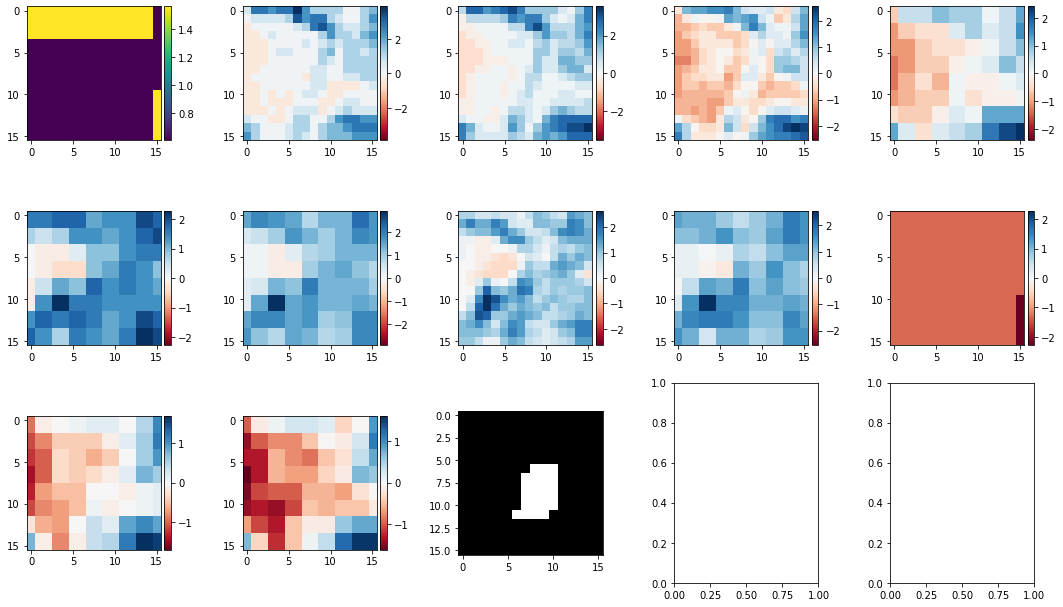

In [24]:
fig, axes = plt.subplots(3, 5, figsize=(s*5, s*3))
print(labels0[ind], crop_dict[crop_labels[labels0[ind].item()]])
for ax, img in zip(axes.ravel(), torch.concat([imgs0[ind], masks0[ind].unsqueeze(0)])):
  plt.sca(ax)
  im = img.numpy()
  io.imshow(im)

tensor(1) Mustard


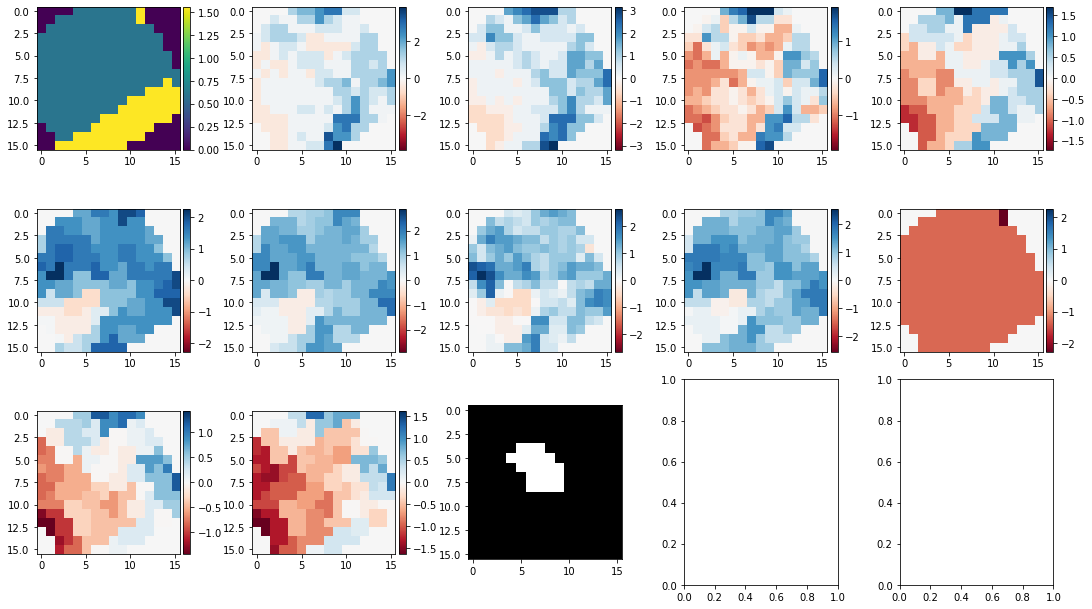

In [25]:
fig, axes = plt.subplots(3, 5, figsize=(s*5, s*3))
print(labels[ind], crop_dict[crop_labels[labels[ind].item()]])
for ax, img in zip(axes.ravel(), torch.concat([imgs[ind], masks[ind].unsqueeze(0)])):
  plt.sca(ax)
  im = img.numpy()
  io.imshow(im)

### Specify the loaders

In [26]:
batch_size = 256

In [27]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)
sampler_tr = torch.utils.data.WeightedRandomSampler(df_train['weight'], 
                                                    len(df_train))
sampler_val = torch.utils.data.WeightedRandomSampler(df_val['weight'],
                                                     len(df_val))

dl_train = torch.utils.data.DataLoader(
    AgriDataset(df_train, 
                transforms=train_transforms,
                ), 
    batch_size=batch_size, num_workers=2,
    drop_last=False,
    sampler=sampler_tr
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(df_val, 
                transforms=validation_transforms,
                ), 
    batch_size=batch_size, num_workers=2,
    shuffle=False,
    drop_last=False,
    sampler=sampler_val
    )

## Specify the training pipeline

### Model and loss

In [28]:
import math

class PositionEmbeddingSine(nn.Module):
    """
    Adapted from https://github.com/facebookresearch/detr/blob/main/models/position_encoding.py
    """

    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, x):
        not_mask = torch.ones((x.shape[0],) + x.shape[-2:])
        y_embed = not_mask.cumsum(1, dtype=torch.float32).to(x.device)
        x_embed = not_mask.cumsum(2, dtype=torch.float32).to(x.device)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * torch.div(dim_t, 2, rounding_mode='trunc') / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos


In [29]:
class Transformer(nn.Module):

    def __init__(self, in_channels, hidden_dim, nheads=8, num_layers=6):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, 
                                                   nhead=nheads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, 
                                                         num_layers=num_layers)
        self.input_embed = nn.Conv2d(in_channels, hidden_dim, 1)
        
        # spatial positional encodings
        self.position_encodings = PositionEmbeddingSine(torch.div(hidden_dim, 
                                                                  2, 
                                                                  rounding_mode='trunc'),
                                                        normalize=True)

    def forward(self, x, mask):
        x = self.input_embed(x)
        mask = (1 - mask).flatten(-2, -1)
        mask[:,0] = 0
        pos = self.position_encodings(x)
        out = self.transformer_encoder((pos + x).flatten(-2, -1).transpose(-1, -2),
                                       src_key_padding_mask=mask)
        return out[:,0]

class TransformerClassifier(nn.Module):

    def __init__(self, in_channels, hidden_dim, num_classes, 
                 nheads=8, num_layers=6):
        super().__init__()
        self.transformer = Transformer(in_channels, hidden_dim, nheads=4)
        self.class_embed = nn.Linear(hidden_dim, num_classes)


    def forward(self, x, mask):
        out = self.transformer(x, mask)
        class_prob = self.class_embed(out)
        return class_prob   

In [30]:
net = TransformerClassifier(in_channels=len(BAND_NAMES), 
                            hidden_dim=len(BAND_NAMES), 
                            num_classes=len(crop_labels),
                            nheads=4).cuda()

In [31]:
net.transformer.load_state_dict(
    torch.load(os.path.join(path, 'models/1667150366_Sun Oct 30 17:19:26 2022_pretraining/best_model.pth'))
    )

<All keys matched successfully>

In [32]:
loss_fn = nn.CrossEntropyLoss().cuda()

### Optimizer and scheduler

In [33]:
lr = 0.001
weight_decay = 0.05
epochs = 50
patience = 10
factor = 0.1
gamma = 0.9

In [34]:
optimizer = torch.optim.AdamW(
    params=[{"params": [p for p in net.parameters() if p.requires_grad]}],
            lr=lr, weight_decay=weight_decay
)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=factor, patience=patience
#     )
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=gamma
    )

### Training step

In [35]:
def train_epoch(net, loss_fn, dl_train, optimizer, lr_scheduler):
  net.train()
  loss_fn.train()
  epoch_loss = 0
  step = 0
  for imgs, masks, targets, _ in tqdm(dl_train):
    step += 1
    optimizer.zero_grad()
    outputs = net(imgs.cuda(), masks.cuda())
    losses = loss_fn(outputs, targets.cuda())
    losses.backward()
    optimizer.step()
    epoch_loss += losses.item()
    # lr_scheduler.step()
  epoch_loss /= step
  return epoch_loss

### Validation step

In [36]:
def validate_epoch(net, loss_fn, dl_val):
  net.eval()
  loss_fn.eval()
  epoch_loss = 0
  step = 0

  with torch.no_grad():
    for imgs, masks, targets, _ in tqdm(dl_val):
      step += 1
      outputs = net(imgs.cuda(), masks.cuda())
      losses = loss_fn(outputs, targets.cuda())
      epoch_loss += losses.item()
  epoch_loss /= step
  return epoch_loss

## Train the model

In [37]:
model_name = rf'{int(time.time())}_{time.ctime()}_transformer'
model_dir = os.path.join(path, 'models', model_name)
os.makedirs(model_dir, exist_ok=True)

In [38]:
%%time
torch.manual_seed(random_seed)
np.random.seed(random_seed)
best_loss = 10**10
train_losses = []
val_losses = []
for epoch in range(epochs):
    # training pass
    train_loss = train_epoch(net, loss_fn, dl_train, optimizer, lr_scheduler)

    # validation pass
    val_loss = validate_epoch(net, loss_fn, dl_val)
    # lr_scheduler.step(val_loss)
    lr_scheduler.step()

    # output
    print(f"epoch {epoch + 1} training loss: {train_loss:.4f}; "
          f"validation loss: {val_loss:.4f}; "
          f"lr: {optimizer.param_groups[0]['lr']}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss <= best_loss:
      best_loss = val_loss
      torch.save(net.state_dict(), os.path.join(model_dir, 'best_model.pth'))
      print('saving best model')
    torch.save(net.state_dict(), os.path.join(model_dir, 'last_model.pth'))

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/transformer.py:456: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at  ../aten/src/ATen/native/transformers/attention.cpp:141.)
  src_mask if src_mask is not None else src_key_padding_mask,  # TODO: split into two args
100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


epoch 1 training loss: 2.5975; validation loss: 2.4814; lr: 0.0009000000000000001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


epoch 2 training loss: 2.3598; validation loss: 2.3707; lr: 0.0008100000000000001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


epoch 3 training loss: 2.1987; validation loss: 2.2192; lr: 0.000729
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


epoch 4 training loss: 2.0953; validation loss: 2.1607; lr: 0.0006561000000000001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


epoch 5 training loss: 2.0283; validation loss: 2.0324; lr: 0.00059049
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


epoch 6 training loss: 1.9452; validation loss: 2.0570; lr: 0.000531441


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch 7 training loss: 1.8845; validation loss: 2.0400; lr: 0.0004782969


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


epoch 8 training loss: 1.8563; validation loss: 2.0659; lr: 0.00043046721


100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


epoch 9 training loss: 1.8321; validation loss: 1.9680; lr: 0.000387420489
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


epoch 10 training loss: 1.7903; validation loss: 2.0523; lr: 0.0003486784401


100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


epoch 11 training loss: 1.7170; validation loss: 2.0616; lr: 0.00031381059609000004


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


epoch 12 training loss: 1.7328; validation loss: 1.9901; lr: 0.00028242953648100003


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch 13 training loss: 1.7283; validation loss: 2.0430; lr: 0.00025418658283290005


100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


epoch 14 training loss: 1.6956; validation loss: 1.9689; lr: 0.00022876792454961005


100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


epoch 15 training loss: 1.6733; validation loss: 2.0990; lr: 0.00020589113209464906


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


epoch 16 training loss: 1.6698; validation loss: 2.1358; lr: 0.00018530201888518417


100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


epoch 17 training loss: 1.6587; validation loss: 2.1300; lr: 0.00016677181699666576


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


epoch 18 training loss: 1.6357; validation loss: 2.2147; lr: 0.0001500946352969992


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


epoch 19 training loss: 1.6605; validation loss: 2.1735; lr: 0.0001350851717672993


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


epoch 20 training loss: 1.6048; validation loss: 2.2072; lr: 0.00012157665459056936


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


epoch 21 training loss: 1.6328; validation loss: 2.1975; lr: 0.00010941898913151243


100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


epoch 22 training loss: 1.6292; validation loss: 2.1836; lr: 9.847709021836118e-05


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


epoch 23 training loss: 1.6264; validation loss: 2.1205; lr: 8.862938119652506e-05


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


epoch 24 training loss: 1.6031; validation loss: 2.2106; lr: 7.976644307687256e-05


100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


epoch 25 training loss: 1.6259; validation loss: 2.1434; lr: 7.17897987691853e-05


100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


epoch 26 training loss: 1.5774; validation loss: 2.2387; lr: 6.461081889226677e-05


100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


epoch 27 training loss: 1.5833; validation loss: 2.1923; lr: 5.81497370030401e-05


100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


epoch 28 training loss: 1.6096; validation loss: 2.2574; lr: 5.233476330273609e-05


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


epoch 29 training loss: 1.5827; validation loss: 2.0931; lr: 4.7101286972462485e-05


100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


epoch 30 training loss: 1.5981; validation loss: 2.2136; lr: 4.239115827521624e-05


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


epoch 31 training loss: 1.5890; validation loss: 2.2274; lr: 3.8152042447694614e-05


100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


epoch 32 training loss: 1.5911; validation loss: 2.2557; lr: 3.433683820292515e-05


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


epoch 33 training loss: 1.5945; validation loss: 2.2292; lr: 3.090315438263264e-05


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


epoch 34 training loss: 1.5762; validation loss: 2.1945; lr: 2.7812838944369376e-05


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


epoch 35 training loss: 1.5575; validation loss: 2.1802; lr: 2.503155504993244e-05


100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


epoch 36 training loss: 1.5823; validation loss: 2.1014; lr: 2.2528399544939195e-05


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


epoch 37 training loss: 1.5520; validation loss: 2.2206; lr: 2.0275559590445276e-05


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch 38 training loss: 1.5646; validation loss: 2.1756; lr: 1.8248003631400748e-05


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


epoch 39 training loss: 1.5525; validation loss: 2.2247; lr: 1.6423203268260675e-05


100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


epoch 40 training loss: 1.5613; validation loss: 2.1921; lr: 1.4780882941434607e-05


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch 41 training loss: 1.5731; validation loss: 2.1924; lr: 1.3302794647291146e-05


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


epoch 42 training loss: 1.5593; validation loss: 2.2921; lr: 1.1972515182562031e-05


100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


epoch 43 training loss: 1.5587; validation loss: 2.1985; lr: 1.0775263664305828e-05


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


epoch 44 training loss: 1.5723; validation loss: 2.1793; lr: 9.697737297875246e-06


100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


epoch 45 training loss: 1.5404; validation loss: 2.1838; lr: 8.727963568087722e-06


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


epoch 46 training loss: 1.5809; validation loss: 2.1079; lr: 7.85516721127895e-06


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


epoch 47 training loss: 1.5733; validation loss: 2.2271; lr: 7.069650490151056e-06


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


epoch 48 training loss: 1.5436; validation loss: 2.2243; lr: 6.362685441135951e-06


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


epoch 49 training loss: 1.5436; validation loss: 2.1998; lr: 5.7264168970223554e-06


100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

epoch 50 training loss: 1.5668; validation loss: 2.1184; lr: 5.15377520732012e-06
CPU times: user 5min 33s, sys: 13.1 s, total: 5min 46s
Wall time: 9min 3s


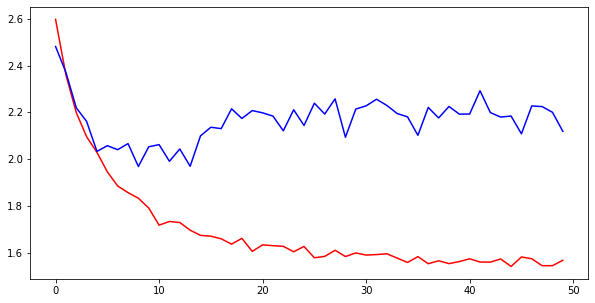

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses,'r')
plt.plot(val_losses, 'b')

## Set up the loaders and model for evaluation

In [40]:
dl_test = torch.utils.data.DataLoader(
    AgriDataset(df_val),
    shuffle=False, drop_last=False, batch_size=16, num_workers=2
    )

In [41]:
net.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pth')))
net.eval();

## Evaluate the model on the validation set

In [42]:
def evaluate(dl_test, net, crop_labels, df_val):
  field_data = []
  outputs = []
  with torch.no_grad():
    for imgs, masks, gt, field_id in tqdm(dl_test):
      output = net(imgs.cuda(), masks.cuda()).softmax(-1).cpu().numpy()
      field_id = field_id.numpy()
      field_data.append(field_id)
      outputs.append(output)
  outputs = np.concatenate(outputs, axis=0)
  outputs_scaled = outputs * df_val['field_area'].values.reshape(-1, 1)

  df_out = pd.DataFrame(outputs_scaled, columns=crop_labels)
  df_out['field_id'] = df_val['field_id']
  df_out['crop_type'] = df_val['crop_type']
  df_sm = df_out.groupby('field_id').sum().reset_index()
  probs = df_sm[crop_labels].values
  probs = probs / np.sum(probs, axis=1).reshape(-1,1)
  crop_types = df_out.groupby('field_id').mean().reset_index()['crop_type'].values
  df_out[crop_labels] = outputs
        
  return probs, np.int_(df_sm['field_id'].values), crop_types, df_out

In [43]:
probs, field_ids, gt, df_out = evaluate(dl_test, net, crop_labels, df_val)

100%|██████████| 70/70 [00:01<00:00, 41.59it/s]


In [44]:
crop_columns = [crop_dict[key] for key in crop_labels]
output_df = pd.DataFrame()
output_df[crop_columns] = df_out[crop_labels].values

output_df['field_id'] = df_val['field_id']
output_df['crop_type'] = df_val['crop_type']
output_df['field_area'] = df_val['field_area']
output_df['data_path'] = df_val['data_path']
output_df['predicted'] = np.array(crop_labels)[np.argmax(output_df[crop_columns].values, axis=1)]

output_df.to_csv(os.path.join(model_dir, 'predictions_val.csv'), index=False)

In [45]:
probs.shape, field_ids.shape, gt.shape

((1077, 13), (1077,), (1077,))

In [46]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

print(classification_report(gt, np.array(crop_labels)[np.argmax(probs, axis=1)]))

              precision    recall  f1-score   support

         1.0       0.40      0.00      0.01       401
         2.0       0.22      0.03      0.05       198
         3.0       0.03      0.30      0.06        20
         4.0       0.84      0.21      0.34       303
         5.0       0.00      0.00      0.00         5
         6.0       0.10      0.75      0.17        32
         8.0       0.07      0.40      0.12        10
         9.0       0.38      0.80      0.52        59
        13.0       0.10      0.25      0.14        12
        14.0       0.02      0.67      0.03         3
        15.0       0.05      0.29      0.09         7
        16.0       0.00      0.00      0.00         2
        36.0       0.11      0.64      0.19        25

    accuracy                           0.16      1077
   macro avg       0.18      0.33      0.13      1077
weighted avg       0.46      0.16      0.15      1077



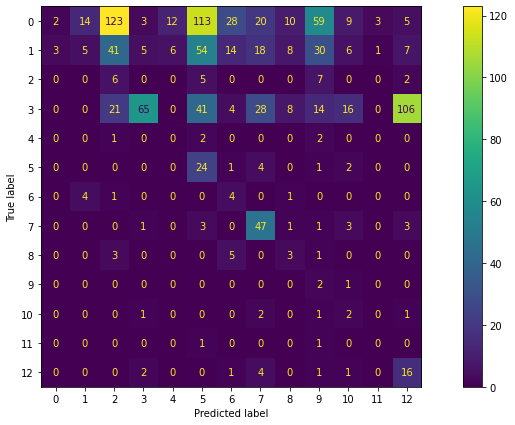

In [47]:
# Confusion matrix
cm = confusion_matrix(gt, np.array(crop_labels)[np.argmax(probs, axis=1)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

In [48]:
def to_one_hot(x):
    y = np.zeros((x.size, x.max() + 1))
    y[np.arange(x.size), x] = 1
    return y

def cross_entropy(predictions, targets):
    return -np.sum(np.sum(np.log(predictions + 10**(-10)) * targets, axis=1))/len(targets)


In [49]:
targets = to_one_hot(np.int_(gt))
targets = targets[:, np.where(targets.sum(axis=0) > 0)[0]]

In [50]:
cross_entropy(probs, targets)

2.2608061721668413

## Evaluate the model on the test set

In [51]:
dl_test = torch.utils.data.DataLoader(
    AgriDataset(df_test), shuffle=False, drop_last=False, 
    batch_size=16, num_workers=2
    )

In [52]:
probs, field_ids, _, _ = evaluate(dl_test, net, crop_labels, df_test)

  0%|          | 0/101 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/transformer.py:456: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at  ../aten/src/ATen/native/transformers/attention.cpp:141.)
  src_mask if src_mask is not None else src_key_padding_mask,  # TODO: split into two args
100%|██████████| 101/101 [00:02<00:00, 45.06it/s]


In [53]:
crop_columns = [crop_dict[key] for key in crop_labels]

output_df = pd.DataFrame(columns=['field_id'] + crop_columns)

output_df['field_id'] = field_ids

output_df[crop_columns] = probs 
output_df.to_csv('submission.csv', index=False)
output_df.to_csv(os.path.join(model_dir, 'predictions_test.csv'), index=False)

In [54]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>